<a href="https://colab.research.google.com/github/Pasindu19970808/RemainingUsefulLifePrediction/blob/main/RUL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import regex as re
from pathlib import Path
import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
configs = {
    'Data Path' : r'/content/drive/My Drive/Colab Notebooks/RUL Prediction/CMaps'
}

In [4]:
# re_rul = re.compile(r'RUL_FD(\w+){3}\.txt')
# re_test = re.compile(r'test_FD(\w+){3}\.txt')
# re_train = re.compile(r'train_FD(\w+){3}\.txt')
re_rul = re.compile(r'RUL_FD001.txt')
re_test = re.compile(r'test_FD001.txt')
re_train = re.compile(r'train_FD001.txt')


test_files = [i for i in Path(configs['Data Path']).iterdir() if re_test.match(i.name)]
test_RUL = [i for i in Path(configs['Data Path']).iterdir() if re_rul.match(i.name)]
train_files = [i for i in Path(configs['Data Path']).iterdir() if re_train.match(i.name)]

In [5]:
def split_name(path):
    file_name = path.stem
    return file_name.split('_')[-1]

def split_data_to_unit(data,col_names = None,cols_to_drop = None):
  if cols_to_drop:
    assert col_names != None,"col_names cannot be None"
  for key,grp in data.groupby(0):
      grp = grp.iloc[:,2:].dropna(axis = 1)
      if cols_to_drop:
        grp.columns = col_names
        grp = grp.drop(cols_to_drop,axis = 1)
      grp = grp.to_numpy()
      yield (key,grp)

def create_data_dictionary(files,col_names = None,cols_to_drop = None):
    data_dictionary = {}
    for file in files:
        data = pd.read_csv(file,header = None,delimiter = ' ')
        engine_name = split_name(file)
        key_data = split_data_to_unit(data,col_names,cols_to_drop)
        for key,data in key_data:
            data_dictionary[f'{engine_name}_{key}'] = data
    return data_dictionary

def get_target_data(data_length):
  return np.arange(data_length - 1,-1,-1)

def get_unit_data_split(data,window_length,shift):
  assert window_length <= data.shape[0],"Window length larger than data length"
  data_length = data.shape[0]
  target_data = get_target_data(data_length)
  #make data into a batch,window_length,num_features shape matrix
  num_batches = int(np.floor((data_length - window_length)/shift)) + 1
  data_template = np.zeros(shape = (num_batches,window_length,data.shape[1]))
  target_data_template = np.zeros(shape = (num_batches,1))
  for batch in range(num_batches):
    batch_data = data[batch*shift : (batch*shift) + (window_length),:]
    data_template[batch,:,:] = batch_data
    target_data_template[batch] = target_data[(batch*shift) + (window_length - 1)]
  return data_template,target_data_template

In [6]:
window_length = 25
shift = 1
concat_list = []
concat_list_targets = []
train_data = create_data_dictionary(train_files)
for key,data in train_data.items():
  x,y = get_unit_data_split(data,window_length,shift)
  concat_list.append(x)
  concat_list_targets.append(y)

In [7]:
complete_ds = np.concatenate(concat_list,axis = 0)
complete_ds_targets = np.concatenate(concat_list_targets,axis = 0)

In [8]:
complete_ds.shape

(18231, 25, 24)

Checking the distribution of attributes

In [9]:
complete_df = pd.DataFrame(np.reshape(complete_ds,newshape = (complete_ds.shape[0]*complete_ds.shape[1],complete_ds.shape[2])))
complete_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,455775.000000,455775.000000,455775.0,4.557750e+05,455775.000000,455775.000000,455775.000000,4.557750e+05,455775.000000,455775.000000,...,455775.000000,455775.000000,455775.000000,455775.000000,4.557750e+05,455775.000000,455775.0,455775.0,455775.000000,455775.000000
mean,-0.000014,0.000003,100.0,5.186700e+02,642.645127,1590.104907,1408.226487,1.462000e+01,21.609810,553.434982,...,521.470647,2388.091244,8142.893227,8.439276,3.000000e-02,393.100767,2388.0,100.0,38.829357,23.297564
std,0.002187,0.000293,0.0,6.821218e-13,0.460672,5.671694,8.103050,3.552718e-15,0.001366,0.802413,...,0.664990,0.066004,16.044579,0.034137,2.428616e-17,1.424208,0.0,0.0,0.165126,0.098752
min,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,-0.001500,-0.000200,100.0,5.186700e+02,642.320000,1586.200000,1402.330000,1.462000e+01,21.610000,552.900000,...,521.030000,2388.040000,8133.620000,8.414600,3.000000e-02,392.000000,2388.0,100.0,38.720000,23.233200
50%,0.000000,0.000000,100.0,5.186700e+02,642.630000,1589.900000,1407.710000,1.462000e+01,21.610000,553.470000,...,521.500000,2388.090000,8140.600000,8.437600,3.000000e-02,393.000000,2388.0,100.0,38.840000,23.301500
75%,0.001500,0.000300,100.0,5.186700e+02,642.950000,1593.780000,1413.550000,1.462000e+01,21.610000,554.010000,...,521.960000,2388.130000,8148.100000,8.461700,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.367200
max,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


<BarContainer object of 24 artists>

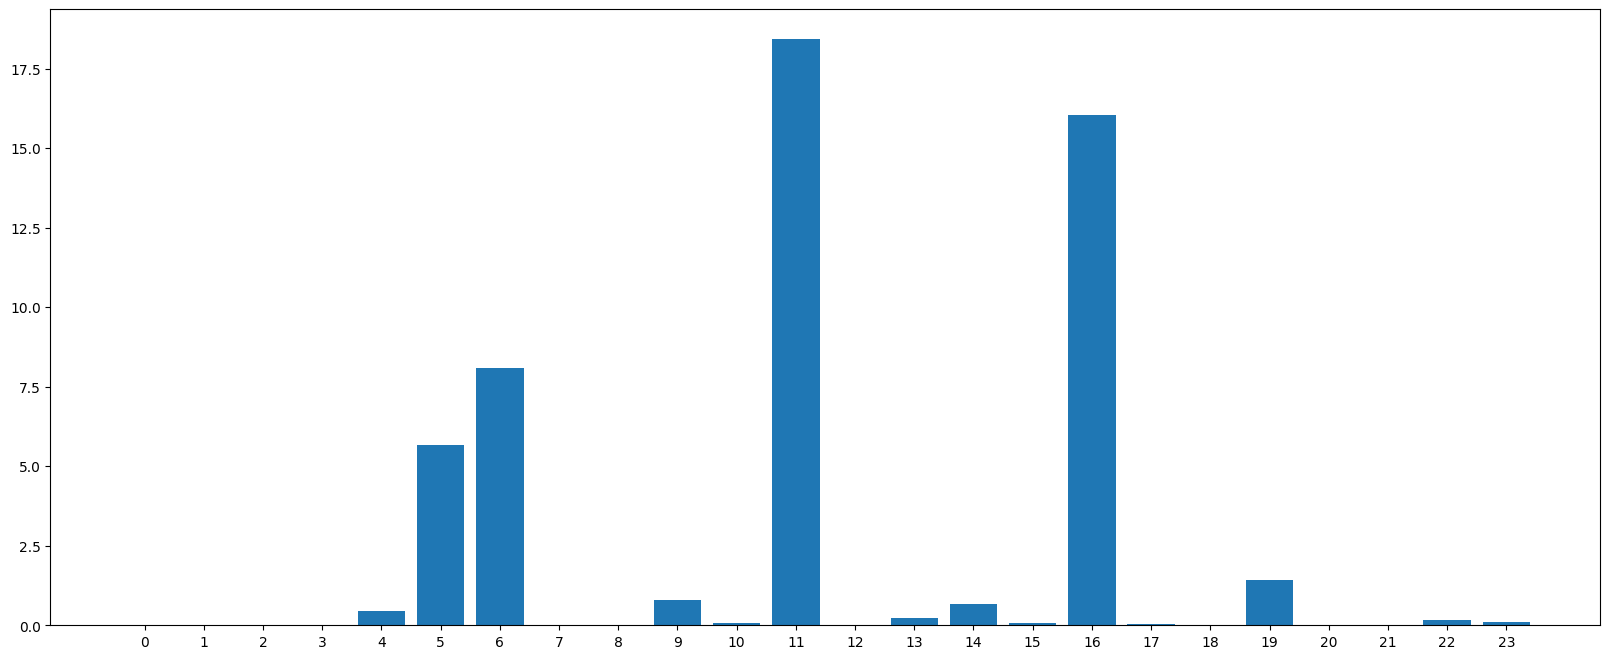

In [10]:
fig,ax = plt.subplots(1,1,figsize = (20,8))
ax.bar(x = complete_df.columns.tolist(),height = complete_df.describe().iloc[2,:].tolist(),tick_label = complete_df.columns.tolist())
# sns.barplot()


Removing unnecessary attributes

In [11]:
col_names = ['op1','op2','op3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13',\
             's14','s15','s16','s17','s18','s19','s20','s21']
col_idx = [0,1,2,3,7,8,12,18,20,21]
cols_to_drop = [col_names[i] for i in col_idx]

Split dataset to train validation splits

In [12]:
window_length = 25
shift = 1
concat_list = []
concat_list_targets = []
train_data = create_data_dictionary(train_files,col_names,cols_to_drop)
for key,data in train_data.items():
  x,y = get_unit_data_split(data,window_length,shift)
  concat_list.append(x)
  concat_list_targets.append(y)

In [13]:
complete_ds_before_scaling = np.concatenate(concat_list,axis = 0)
complete_ds_targets = np.concatenate(concat_list_targets)

In [14]:
complete_ds_before_scaling.shape

(18231, 25, 14)

Scaling the data

In [15]:
scaling_complete_ds = np.reshape(complete_ds_before_scaling,newshape = (complete_ds_before_scaling.shape[0]*complete_ds_before_scaling.shape[1],-1))
scaler = StandardScaler()
scaling_complete_ds = scaler.fit_transform(scaling_complete_ds)
complete_ds = np.reshape(scaling_complete_ds,newshape = (complete_ds_before_scaling.shape[0],
                                                         complete_ds_before_scaling.shape[1],
                                                         complete_ds_before_scaling.shape[2]))

Splitting to Training and Validation

In [16]:
total_indexes = np.arange(0,complete_ds.shape[0],1)
train_X_idx,val_X_idx = train_test_split(total_indexes,test_size = 0.2,random_state = 42,shuffle = True)

In [17]:
train_X = complete_ds[train_X_idx,:,:]
train_Y = complete_ds_targets[train_X_idx]

val_X = complete_ds[val_X_idx,:,:]
val_Y = complete_ds_targets[val_X_idx]

In [31]:
class EngineDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,index):
    x = self.X[index,:,:]
    #https://discuss.pytorch.org/t/runtimeerror-input-and-hidden-tensors-are-not-the-same-dtype-found-input-tensor-with-double-and-hidden-tensor-with-float/139087/2
    x = torch.from_numpy(x).float()
    y = self.y[index]
    return x,y

In [32]:
train_dataset = EngineDataset(train_X,train_Y)
val_dataset = EngineDataset(val_X,val_Y)

In [33]:
train_dataloader = DataLoader(train_dataset,batch_size = 4,shuffle = True)
val_dataloader = DataLoader(train_dataset,batch_size = 4,shuffle = True)

In [34]:
complete_ds.shape

(18231, 25, 14)

Model Architeture 1:

BiLSTM

In [75]:
class modelBiLSTM(nn.Module):
  def __init__(self,input_size,hidden_size,dropout = 0.5):
    super(modelBiLSTM,self).__init__()
    #In bidirectional LSTM the output hidden_states h_n(second item in tupled)
    #contains the final hidden state from both directions for each item in batch
    self.lstm = nn.LSTM(input_size = input_size,
                        hidden_size = hidden_size,
                        batch_first = True,
                        bidirectional = True)
    self.bnorm1 = nn.BatchNorm1d(hidden_size*2)
    self.linear1 = nn.Linear(in_features = hidden_size*2,out_features = hidden_size)
    self.bn2 = nn.BatchNorm1d(hidden_size)
    self.drop = nn.Dropout(dropout)
    self.linear2 = nn.Linear(in_features = hidden_size,out_features = 1)
  def forward(self,X):
    x = self.lstm(X)
    #combines the final forward and backward hidden states
    x = torch.concat((x[1][0][0,:,:],x[1][0][1,:,:]),axis = 1)
    x = self.bnorm1(x)
    x = self.linear1(x)
    x = self.bn2(x)
    x = self.drop(x)
    x = self.linear2(x)
    return x

In [67]:
#put this in a train function
#shape of data = [N,25,14]
#https://github.com/pytorch/examples/blob/2639cf050493df9d3cbf065d45e6025733add0f4/imagenet/main.py#L268
def validate(model,val_dataloader,criterion):
  model.eval()
  val_loss = []
  with torch.no_grad():
    for i,j in enumerate(val_dataloader):
      X = j[0].to(device)
      true_rul = j[1].to(device)

      pred_rul = model(X)
      loss = criterion(pred_rul,true_rul)

      val_loss.append(loss.item())
  average_loss  = np.array(val_loss).mean()
  return average_loss,model

def train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion):
  epoch_loss = []
  val_loss = []
  for epoch in range(epoch):
    model.train()
    batch_loss = []
    for i,j in enumerate(train_dataloader):
      X = j[0].to(device)
      true_rul = j[1].to(device)
      optimizer.zero_grad()

      pred_rul = model(X)
      loss = criterion(pred_rul,true_rul)

      loss.backward()
      optimizer.step()

      batch_loss.append(loss.item())
    epoch_loss.append(np.array(batch_loss).mean())
    val_loss,model = validate(model,val_dataloader,criterion)
  return model,epoch_loss,val_loss

Trying for 10 epochs with LR = 1E-3 as first attempt

In [ ]:
epoch_number = 10
model = modelBiLSTM(14,7).to(device)
optimizer = torch.optim.Adam(model.parameter(),lr = 0.001)
criterion = nn.MSELoss()
model,epoch_loss,val_loss = train(model,epoch_number,train_dataloader,val_dataloader,optimizer,criterion)